In [12]:
%texify

The notexbook extension is already loaded. To reload it, use:
  %reload_ext notexbook


# Analiza zbioru danych związanych z katastrofą Titanica
### Na podsawie poniższej analizy chciałbym zobaczyć i możliwie określić wpływ czynników związanych z przeżywalonością pasażerów statku

## 1. Określenie Problemu
### Zrozumienie wpływu czynników decydujących na przezprzywalności pasażerów podczas katastrofy Titanica.
* Czy istnieje różnica w szansach przeżycia między mężczyznami a kobietami?
* Czy klasa biletu wpływa na szanse przeżycia?
* Czy wiek pasażera wpływa na jego szanse przeżycia?
* Czy inne czynniki, takie jak miejsce na statku, stan cywilny lub narodowość, wpływają na szanse przeżycia?cia?

## 1a. Dodatkowe pytania które chciałbym sprawdzić 
* Cena biletua, a port zaokrętowania. 
* Stan cywilny
* Średni wiek

## 2. Wstępne zapoznanie się z danymi 
### Załadowanie podstawowych bibliotek, oraz bazy danych.

In [13]:
#Obliczenia  i analiza  danych
import numpy as np
import pandas as pd

#wizualiacja 
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
#Przetwarzanie
from sklearn.preprocessing import OneHotEncoder

# Baza danych
Titanic = pd.read_csv("Titanic_Database.csv") 

In [14]:
Titanic.head(8)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S


In [15]:
print(Titanic.columns)

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')


### Zbiór danych zawiera następujące informacje:

*  PassengerId: Unikatowy identyfikator pasażera
*  Survived: Czy pasażer przeżył (1) czy zginął (0)
*  Pclass: Klasa biletu (1=pierwsza, 2=druga, 3=trzecia)
*  Name: Imię i nazwisko pasażera, staus cywilny
*  Sex: Płeć pasażera (male, female)
*  Age: Wiek pasażera
*  SibSp: Liczba rodzeństwa i/lub małżonka na pokładzie
*  Parch: Liczba rodziców i/lub dzieci na pokładzie
*  Ticket: Numer biletu
*  Fare: Cena biletu
*  Cabin: Numer kabiny
*  Embarked: Port zaokrętowania (C = Cherbourg, Q = Queenstown, S = Southampton)

In [16]:
Titanic.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


## 3. Czyszczenie i przygotowanie danych

In [17]:
#Sprawdzenie wartości zerowych
print(pd.isnull(Titanic).sum())

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


### Przygotowanie danych

In [18]:
Titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


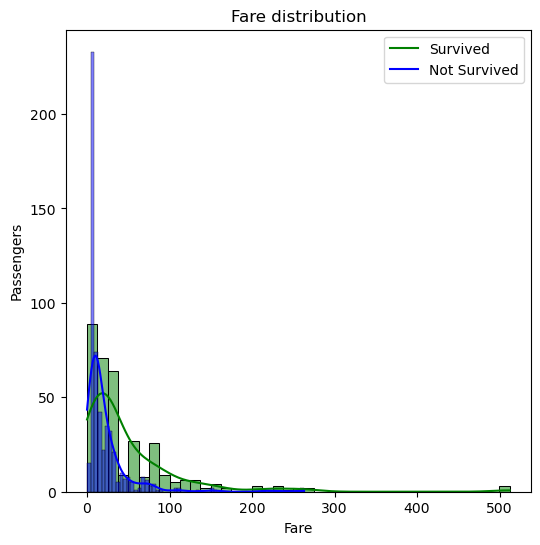

In [19]:
fig, axes = plt.subplots(figsize=(6,6))
axes.set_ylabel('Passengers')
axes.set_title('Fare distribution')
sns.histplot(Titanic[Titanic['Survived']==1]['Fare'],kde=True,color='green')
sns.histplot(Titanic[Titanic['Survived']==0]['Fare'],kde=True,color='blue')
axes.legend(['Survived','Not Survived'])

In [20]:
# Mapping Fare
#Titanic.loc[Titanic['Fare'] <=  7.895800,                                 'Fare'] = 0
#Titanic.loc[(Titanic['Fare'] >  7.895800) & (Titanic['Fare'] <= 14.4542), 'Fare'] = 1
#Titanic.loc[(Titanic['Fare'] > 14.4542)   & (Titanic['Fare'] <=  31.5),   'Fare'] = 2
#Titanic.loc[Titanic['Fare'] >  31.5,                                      'Fare'] = 3
#Titanic['Fare'].value_counts()

####  Określenie stanu cywilnego danego paseżera.

In [21]:
def get_title(name):
    # Wyodrębnij prefix z imienia
    title = name.split(',')[1].split('.')[0].strip()
    if title in ['Lady', 'Countess', 'Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona']:
        return 'Rare'
    elif title in ['Mlle']:
        return 'Miss'
    elif title in ['Ms']:
        return 'Miss'
    elif title in ['Mme']:
        return 'Mrs'
    else:
        return title
Titanic['Title'] = Titanic['Name'].apply(get_title)
title_percentages = Titanic['Title'].value_counts(normalize=True)
print(title_percentages)

Title
Mr              0.580247
Miss            0.207632
Mrs             0.141414
Master          0.044893
Rare            0.024691
the Countess    0.001122
Name: proportion, dtype: float64


### OneHotencodowanie danych categorycznych

In [22]:
#OneHotEncoder
ohe = OneHotEncoder(sparse_output=False)

# Zdefiniuj kolumny do zenkodowania
categorical_features = ['Sex', 'Embarked', 'Title']

# Zenkoduj kolumny
encoded_features = ohe.fit_transform(Titanic[categorical_features])


# Dodaj zakodowane kolumny do DataFrame
for i, col in enumerate(categorical_features):
    Titanic[col + "_Enc"] = encoded_features[:, i]

for col in categorical_features:
    print(f"Kolumna: {col}")
    mapping = ohe_mapping[col]
    for category, encoded_value in mapping.items():
        print(f"  {category}: {encoded_value}")
    print()    

Kolumna: Sex


NameError: name 'ohe_mapping' is not defined

## Wybór danych

In [ ]:
# Usuń oryginalne kolumny
categorical_features = ['PassengerId','Name', 'Title', 'Sex', 'Ticket','Cabin', 'Embarked']
Titanic.drop(columns=categorical_features, inplace=True)
Titanic.tail()

In [ ]:
Titanic[['Age', 'Fare']] = Titanic[['Age', 'Fare']].astype(np.float32)
columns_to_convert = ['Survived' ,'Pclass', 'SibSp', 'Parch', 'Sex_Enc', 'Embarked_Enc', 'Title_Enc']
Titanic[columns_to_convert] = Titanic[columns_to_convert].astype(np.int16)
Titanic.info()

In [ ]:
Titanic

## 4. Wizualizacja i ekspoloracja wzorców

In [ ]:
Titanic.groupby('Sex_Enc').mean()

In [ ]:
colormap = plt.cm.RdBu
plt.figure(figsize=(9,9))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(Titanic.astype(float).corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)